# Structure queries with SQLAlchemy

Test use of SQLAlchemy expression constructs instead of raw SQL for molecular queries.

In [1]:
import pandas as pd
from pandas import DataFrame

from rdkit import Chem, rdBase
from rdkit.Chem import AllChem, Draw, rdqueries, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole

import sqlalchemy
from sqlalchemy import create_engine, Table, MetaData
from sqlalchemy.sql import select, text

In [2]:
conn = create_engine('postgresql://akokai@localhost/chmdata')

# Reflect database table metadata: ✔

SQLAlchemy does not recognize `Mol` data type.

In [3]:
meta = MetaData(conn)
# meta.reflect()  # This would load metadata for all tables

# Load metadata for just the table on which we will make queries
# (Should wrap in try/except)
cpds = Table('cpds', meta, autoload=True)

/opt/akokai/anaconda/envs/cmldev/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2517: SAWarning: Did not recognize type 'mol' of column 'molecule'
  (attype, name))


In [4]:
cpds.columns.items()

[('dtxsid', Column('dtxsid', VARCHAR(), table=<cpds>)),
 ('cid', Column('cid', TEXT(), table=<cpds>)),
 ('casrn', Column('casrn', VARCHAR(), table=<cpds>)),
 ('name', Column('name', VARCHAR(), table=<cpds>)),
 ('inchikey', Column('inchikey', VARCHAR(), table=<cpds>)),
 ('inchi', Column('inchi', VARCHAR(), table=<cpds>)),
 ('molecule', Column('molecule', NullType(), table=<cpds>))]

## Set some frequently accessed parameters

In [5]:
# For DataFrames:
cols = cpds.columns.keys()
print(cols)
# For SQL:
molcol = cpds.columns.molecule
print(molcol)

['dtxsid', 'cid', 'casrn', 'name', 'inchikey', 'inchi', 'molecule']
cpds.molecule


# Basic query using Python expressions: 💯

In [6]:
que = select([cpds]).where(cpds.c.cid == '4')
res = conn.execute(que)
ret = res.fetchall()
res.close()
print(ret)

[('DTXSID9021764', '4', '78-96-6', '1-Amino-2-propanol', 'HXKKHQJGJAFBHI-UHFFFAOYSA-N', 'InChI=1S/C3H9NO/c1-3(5)2-4/h3,5H,2,4H2,1H3', 'CC(O)CN')]


# Use custom `@>` operator: 💯

Search for phenol structures.

In [7]:
smiles = 'c1(O)ccccc1'
que = select([cpds]).where(cpds.c.molecule.op('@>')(smiles)).limit(5)
print(str(que))

SELECT cpds.dtxsid, cpds.cid, cpds.casrn, cpds.name, cpds.inchikey, cpds.inchi, cpds.molecule 
FROM cpds 
WHERE cpds.molecule @> %(molecule_1)s 
 LIMIT %(param_1)s


In [8]:
res = conn.execute(que)
print(res.rowcount, 'rows')
df = DataFrame(res.fetchall(), columns=cols)
res.close()
df

5 rows


,dtxsid,cid,casrn,name,inchikey,inchi,molecule
0,DTXSID20734279,61751165,823226-19-3,1-(4-Chlorobutoxy)-4-(methanesulfonyl)benzene,HFYRLRUSFGDXMF-UHFFFAOYSA-N,"InChI=1S/C11H15ClO3S/c1-16(13,14)11-6-4-10(5-7...",CS(=O)(=O)c1ccc(OCCCCCl)cc1
1,DTXSID60735689,66743914,889362-82-7,3-tert-Butoxy-5-fluoroaniline,HMCDSAJLOQMLLW-UHFFFAOYSA-N,"InChI=1S/C10H14FNO/c1-10(2,3)13-9-5-7(11)4-8(1...",CC(C)(C)Oc1cc(N)cc(F)c1
2,DTXSID90746526,None,109738-21-8,"Oxovanadium(2+) 2,9,16,23-tetraphenoxy-20,27,2...",QLJKMZISJZORJD-UHFFFAOYSA-N,InChI=1S/C56H38N8O4.O.V/c1-5-13-33(14-6-1)65-3...,[O].[V+2].c1ccc(Oc2ccc3c4[n-]c([nH]c5[nH]c([nH...
3,DTXSID90746566,None,155773-71-0,"Nickel(2+) 1,4,8,11,15,18,22,25-octabutoxy-20,...",JGHRWXPBSMJGCS-UHFFFAOYSA-N,InChI=1S/C64H86N8O8.Ni/c1-9-17-33-73-41-25-26-...,CCCCOc1ccc(OCCCC)c2c3[n-]c([nH]c4[nH]c([nH]c5[...
4,DTXSID50746567,71311452,149820-65-5,"(8xi,9R)-6'-Methoxy-9-[(6-{[(4beta,9R)-6'-meth...",SWKRDCRSJPRVNF-RMMANSCUSA-N,InChI=1S/C56H60N6O4/c1-5-35-33-61-27-23-39(35)...,CCC1CN2CC[C@@H]1CC2[C@H](Oc1nc(-c2ccccc2)nc(O[...


# Use `qmol` operand: ✔ (with `text`)

Search for phenyl with plain SMARTS substructure search (matches bezene with one or more substituent).

In [9]:
smarts = 'c1ccccc1-*'
que = select([cpds]).where(text("{0} @> '{1}'::qmol".format(molcol, smarts))).limit(5)
print(str(que))
res = conn.execute(que)
print(res.rowcount)
df = DataFrame(res.fetchall(), columns=cols)
res.close()
df

SELECT cpds.dtxsid, cpds.cid, cpds.casrn, cpds.name, cpds.inchikey, cpds.inchi, cpds.molecule 
FROM cpds 
WHERE cpds.molecule @> 'c1ccccc1-*'::qmol 
 LIMIT %(param_1)s
5


,dtxsid,cid,casrn,name,inchikey,inchi,molecule
0,DTXSID20734279,61751165,823226-19-3,1-(4-Chlorobutoxy)-4-(methanesulfonyl)benzene,HFYRLRUSFGDXMF-UHFFFAOYSA-N,"InChI=1S/C11H15ClO3S/c1-16(13,14)11-6-4-10(5-7...",CS(=O)(=O)c1ccc(OCCCCCl)cc1
1,DTXSID60735689,66743914,889362-82-7,3-tert-Butoxy-5-fluoroaniline,HMCDSAJLOQMLLW-UHFFFAOYSA-N,"InChI=1S/C10H14FNO/c1-10(2,3)13-9-5-7(11)4-8(1...",CC(C)(C)Oc1cc(N)cc(F)c1
2,DTXSID70735791,66796542,51303-72-1,(2-Fluoroethanesulfonyl)benzene,KSSCPGBAPDVQEE-UHFFFAOYSA-N,"InChI=1S/C8H9FO2S/c9-6-7-12(10,11)8-4-2-1-3-5-...",O=S(=O)(CCF)c1ccccc1
3,DTXSID60735780,66788907,140449-09-8,[(Iodomethanesulfonyl)methyl]benzene,JDWWZZSCTWOKAG-UHFFFAOYSA-N,"InChI=1S/C8H9IO2S/c9-7-12(10,11)6-8-4-2-1-3-5-...",O=S(=O)(CI)Cc1ccccc1
4,DTXSID80746499,None,39001-65-5,"Zinc 2,9,16,23-tetra-tert-butyl-20,27,29,31-te...",ABEFKSDOXYFJAU-UHFFFAOYSA-N,"InChI=1S/C48H54N8.Zn/c1-45(2,3)25-13-17-29-33(...",CC(C)(C)c1ccc2c3[n-]c([nH]c4[nH]c([nH]c5[n-]c(...


# Combine RDKit query adjustments with SQLAlchemy queries: 💯

Search for phenyl and adjust query to limit substitution to just *one* substituent.

This modifies the SMARTS pattern, applying the default parameters of `rdkit.Chem.AdjustQueryProperties()` which are described [here](http://www.rdkit.org/Python_Docs/rdkit.Chem.rdmolops-module.html) and [here](http://www.rdkit.org/Python_Docs/rdkit.Chem.rdmolops.AdjustQueryParameters-class.html) as well as in [this blogpost](http://rdkit.blogspot.com/2016/07/tuning-substructure-queries-ii.html). (We could have used other parameters too.)

In [10]:
smarts = 'c1ccccc1-[*]'
qmol = Chem.AdjustQueryProperties(Chem.MolFromSmarts(smarts))
smarts_adj = Chem.MolToSmarts(qmol)
que = select([cpds]).where(text("{0} @> '{1}'::qmol".format(molcol, smarts_adj))).limit(5)
print(str(que))
res = conn.execute(que)
print(res.rowcount)
df = DataFrame(res.fetchall(), columns=cols)
res.close()
df

SELECT cpds.dtxsid, cpds.cid, cpds.casrn, cpds.name, cpds.inchikey, cpds.inchi, cpds.molecule 
FROM cpds 
WHERE cpds.molecule @> '[c&D2]1:,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D3]:,-1-*'::qmol 
 LIMIT %(param_1)s
5


,dtxsid,cid,casrn,name,inchikey,inchi,molecule
0,DTXSID70735791,66796542,51303-72-1,(2-Fluoroethanesulfonyl)benzene,KSSCPGBAPDVQEE-UHFFFAOYSA-N,"InChI=1S/C8H9FO2S/c9-6-7-12(10,11)8-4-2-1-3-5-...",O=S(=O)(CCF)c1ccccc1
1,DTXSID60735780,66788907,140449-09-8,[(Iodomethanesulfonyl)methyl]benzene,JDWWZZSCTWOKAG-UHFFFAOYSA-N,"InChI=1S/C8H9IO2S/c9-7-12(10,11)6-8-4-2-1-3-5-...",O=S(=O)(CI)Cc1ccccc1
2,DTXSID90746526,None,109738-21-8,"Oxovanadium(2+) 2,9,16,23-tetraphenoxy-20,27,2...",QLJKMZISJZORJD-UHFFFAOYSA-N,InChI=1S/C56H38N8O4.O.V/c1-5-13-33(14-6-1)65-3...,[O].[V+2].c1ccc(Oc2ccc3c4[n-]c([nH]c5[nH]c([nH...
3,DTXSID30746505,71311253,167093-23-4,PUBCHEM_71311253,JWPNATQHLXEGSZ-UHFFFAOYSA-M,InChI=1S/C56H38N8S4.Al.ClH/c1-5-17-33(18-6-1)6...,[Al+3].[Cl-].c1ccc(Sc2cccc3c4[n-]c([nH]c5[nH]c...
4,DTXSID50746567,71311452,149820-65-5,"(8xi,9R)-6'-Methoxy-9-[(6-{[(4beta,9R)-6'-meth...",SWKRDCRSJPRVNF-RMMANSCUSA-N,InChI=1S/C56H60N6O4/c1-5-35-33-61-27-23-39(35)...,CCC1CN2CC[C@@H]1CC2[C@H](Oc1nc(-c2ccccc2)nc(O[...


Do a different search: *meta*-halogen-substituted phenyl.

- I don't know what exactly causes the error, but it doesn't seem to affect what I'm trying to do!
- **Visualizing query molecule:** OK, but displays `[F,Cl,Br,I]` as just `F`.

/opt/akokai/anaconda/envs/cmldev/lib/python3.5/site-packages/cairocffi/surfaces.py:651: UserWarning: implicit cast from 'char *' to a different pointer type: will be forbidden in the future (check that the types are as you expect; use an explicit ffi.cast() if they are correct)
  ffi.cast('char*', address), format, width, height, stride)
RDKit ERROR: [18:20:11] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 174 in file /home/rdkit/miniconda/conda-bld/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [18:20:11] Can't kekulize mol 
RDKit ERROR: 


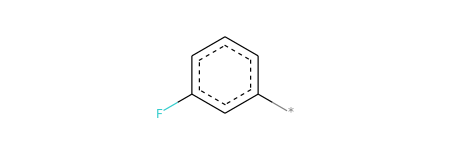

In [11]:
smarts = 'c1c([F,Cl,Br,I])cccc1-[*]'
qmol = Chem.MolFromSmarts(smarts)
qmol

/opt/akokai/anaconda/envs/cmldev/lib/python3.5/site-packages/cairocffi/surfaces.py:651: UserWarning: implicit cast from 'char *' to a different pointer type: will be forbidden in the future (check that the types are as you expect; use an explicit ffi.cast() if they are correct)
  ffi.cast('char*', address), format, width, height, stride)
RDKit ERROR: [18:20:11] Can't kekulize mol 
RDKit ERROR: 


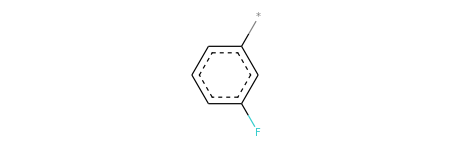

In [12]:
new_qmol = Chem.AdjustQueryProperties(qmol)
new_qmol

In [13]:
smarts_adj = Chem.MolToSmarts(new_qmol)
que = select([cpds]).where(text("{0} @> '{1}'::qmol".format(molcol, smarts_adj))).limit(12)
print(str(que))
res = conn.execute(que)
print(res.rowcount)
df = DataFrame(res.fetchall(), columns=cols)
res.close()
df

SELECT cpds.dtxsid, cpds.cid, cpds.casrn, cpds.name, cpds.inchikey, cpds.inchi, cpds.molecule 
FROM cpds 
WHERE cpds.molecule @> '[c&D2]1:,-[c&D3](-,:[F,Cl,Br,I]):,-[c&D2]:,-[c&D2]:,-[c&D2]:,-[c&D3]:,-1-*'::qmol 
 LIMIT %(param_1)s
12


,dtxsid,cid,casrn,name,inchikey,inchi,molecule
0,DTXSID60736030,66918138,718640-78-9,[2-(3-Chlorophenyl)ethenyl](hydroxy)boranyl,RGZANGPIXJVTJA-UHFFFAOYSA-N,InChI=1S/C8H7BClO/c10-8-3-1-2-7(6-8)4-5-9-11/h...,O[B]C=Cc1cccc(Cl)c1
1,DTXSID60736494,67131250,32222-44-9,Methyl (2S)-(3-chlorophenyl)(hydroxy)acetate,CPEZVACFWJSZNE-QMMMGPOBSA-N,InChI=1S/C9H9ClO3/c1-13-9(12)8(11)6-3-2-4-7(10...,COC(=O)[C@@H](O)c1cccc(Cl)c1
2,DTXSID80746696,71312007,1092502-33-4,2-(3-Chloroanilino)-N-[(pyridin-4-yl)methyl]-4...,UBHSVFAUAKIVKL-UHFFFAOYSA-N,InChI=1S/C18H13ClF3N5O.ClH/c19-12-2-1-3-13(8-1...,Cl.OC(=NCc1ccncc1)c1cnc(Nc2cccc(Cl)c2)nc1C(F)(F)F
3,DTXSID80736491,67130414,87579-16-6,N-[3-(3-Chlorophenyl)acryloyl]-L-tryptophan,DIDZVVHZVZLSDD-SFHVURJKSA-N,InChI=1S/C20H17ClN2O3/c21-15-5-3-4-13(10-15)8-...,O=C(O)[C@H](Cc1c[nH]c2ccccc12)N=C(O)C=Cc1cccc(...
4,DTXSID90764583,71336806,112841-05-1,3-Bromo-N-(2-chloro-5-methylpyridin-3-yl)benza...,WBLLTXUOWMIIPJ-UHFFFAOYSA-N,InChI=1S/C13H10BrClN2O/c1-8-5-11(12(15)16-7-8)...,Cc1cnc(Cl)c(N=C(O)c2cccc(Br)c2)c1
5,DTXSID50638478,24194258,56966-93-9,[(4-{(E)-[(3-Chlorophenyl)imino]methyl}-3-meth...,DZUOIDPZEDMEHJ-WXXHTBLMSA-N,InChI=1S/C20H25ClN2O6S2.ClH/c1-16-13-20(8-7-17...,Cc1cc(N(CCOS(C)(=O)=O)CCOS(C)(=O)=O)ccc1/C=N/c...
6,DTXSID90846570,71427833,918130-77-5,3-Acetyl-5-[(3-chlorophenyl)methylidene]thiola...,FHJSPONQWSHHLW-UHFFFAOYSA-N,InChI=1S/C13H9ClO3S/c1-7(15)11-12(16)10(18-13(...,CC(=O)C1C(=O)SC(=Cc2cccc(Cl)c2)C1=O
7,DTXSID90750244,71320272,88801-93-8,Benzenesulfonic acid--(3-bromophenyl)methanol ...,DEMIUOWEDZRKRP-UHFFFAOYSA-N,InChI=1S/C7H7BrO.C6H6O3S/c8-7-3-1-2-6(4-7)5-9;...,O=S(=O)(O)c1ccccc1.OCc1cccc(Br)c1
8,DTXSID50750245,71320273,88801-94-9,4-Methylbenzene-1-sulfonic acid--(3-bromopheny...,UMYXRFYMEFBKRD-UHFFFAOYSA-N,InChI=1S/C7H7BrO.C7H8O3S/c8-7-3-1-2-6(4-7)5-9;...,Cc1ccc(S(=O)(=O)O)cc1.OCc1cccc(Br)c1
9,DTXSID10750246,71320274,88801-95-0,(3-Bromophenyl)methyl 3-nitrobenzene-1-sulfonate,ZYCJQJYDBCOCMW-UHFFFAOYSA-N,InChI=1S/C13H10BrNO5S/c14-11-4-1-3-10(7-11)9-2...,O=[N+]([O-])c1cccc(S(=O)(=O)OCc2cccc(Br)c2)c1


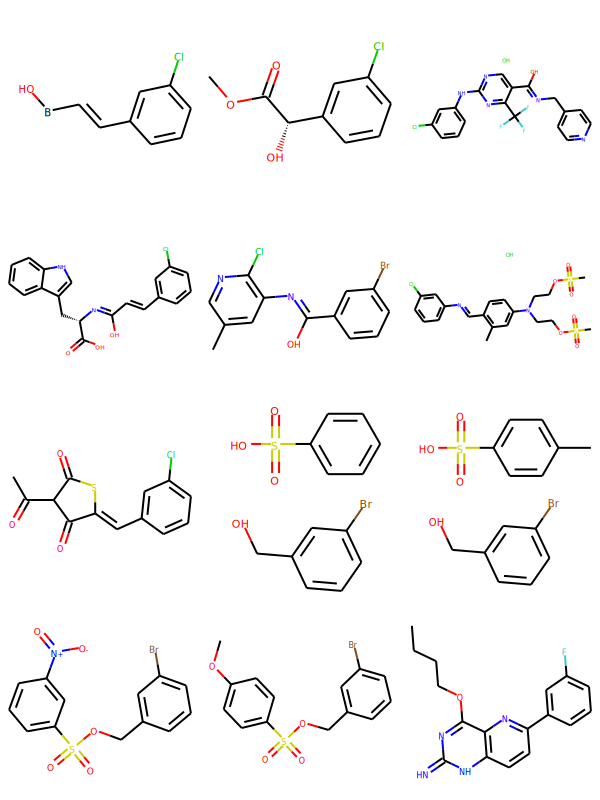

In [14]:
df['molecule'] = df.inchi.apply(Chem.MolFromInchi)
Draw.MolsToGridImage(df.loc[:, 'molecule'])